## Callbacks and learning rate scheduling

Many deep learning approaches can be very sensitive to the right choice of learning rate, and selecting it is not always easy. Too low and the training takes a long time with the risk of getting stuck in a local minimum, while too high and the training may not converge, as we saw in notebook 5.

**Learning rate scheduling** is a dynamic approach to solving this problem, by changing the learning rate as training progresses.

While on the topic we will also have a look at Keras _callbacks_, which allows us to monitor and change the training loop. One of the main things callbacks can be used for is to stop the training before the models start overfitting.

In [1]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

### Load data

For this notebook we look at a famous image dataset called [CIFAR-10](https://en.wikipedia.org/wiki/CIFAR-10), which consists of 60k small images of ten different images. For training modern computer vision models, everyone is using the [ImageNet](https://en.wikipedia.org/wiki/ImageNet) database, but this is somewhat overkill for us at this point.

Conveniently enough, CIFAR-10 can be easily downloaded through `keras.datasets` and is already pre-processed so that images are quadratic and centered, and each image contains only one (1) object.

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


These are the label names:

In [3]:
label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

Plot first nine images.

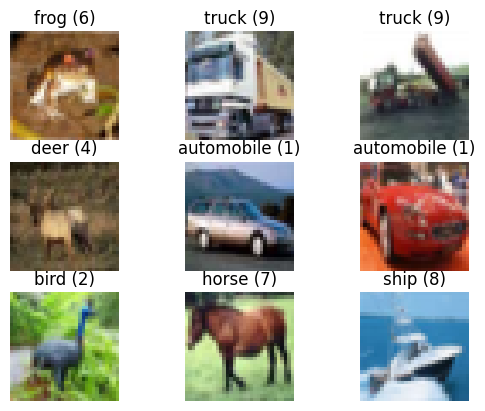

In [4]:
_, ax = plt.subplots(nrows=3, ncols=3)
for i in range(9):
    label_number = np.argmax(y_train[i])
    ax[i // 3, i % 3].imshow(X_train[i])
    ax[i // 3, i % 3].set_title(f'{label_names[label_number]} ({label_number})')
    ax[i // 3, i % 3].axis("off")


### Define the model

Our task will be to classify the images into one of the ten categories. We define a convolutional neural network, which for the purposes of this notebook, is more complicated than it needs to be.

In [5]:
# Construct the model in a function, so that it is quick to create new models
# for each of our experiments.
def make_model():
    m = keras.Sequential([
        keras.layers.Input(shape=(32, 32, 3)),
        keras.layers.Rescaling(1.0 / 255),
        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])

    return m


For these experiments, we use the simplest optimisation algorithm -- standard stochastic gradient descent (SGD), and give it a try with learning rate of 0.01.

In [7]:
model = make_model()

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

`model.fit` returns a dictionary with results for each training epoch. Keep this so that we can plot it later.

Now start the training:

In [8]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=128,
    epochs=25
)

Epoch 1/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.1423 - loss: 2.2940 - val_accuracy: 0.2125 - val_loss: 2.1071
Epoch 2/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2349 - loss: 2.0740 - val_accuracy: 0.2537 - val_loss: 2.0459
Epoch 3/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3138 - loss: 1.9131 - val_accuracy: 0.3437 - val_loss: 1.8676
Epoch 4/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3742 - loss: 1.7698 - val_accuracy: 0.4178 - val_loss: 1.6366
Epoch 5/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4149 - loss: 1.6357 - val_accuracy: 0.4531 - val_loss: 1.5364
Epoch 6/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4488 - loss: 1.5417 - val_accuracy: 0.4840 - val_loss: 1.4737
Epoch 7/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4794 - loss: 1.4673 - val_accuracy: 0.4854 - val_loss: 1.4426
Epoch 8/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.4967 - loss: 1.4092 - val_

With the training completed, we can visualise the above numbers in a plot to make a better comparison.

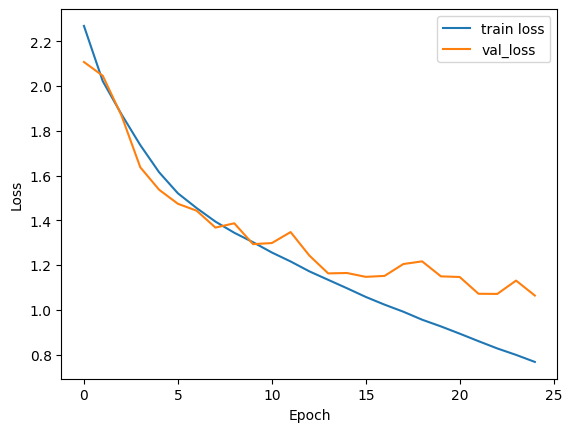

In [9]:
def plot_history(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plot_history(history)

### <span style="color: red;">Exercise:<span>

By looking the above plot, reflect on whether the model will perform good or bad on an unseen test set.

### First look at callbacks

When the model begins to overfit, validation loss goes up while training loss continues going down. One approach to avoiding overfitting, is to stop training when this happens. To do so, we need to monitor the loss (or other metrics) during training, and interrupt the training loop accordingly. Keras calls such tools _callbacks_. They can be triggered at the end of an epoch, or start of an epoch, or end of a batch, and so on.

The callback we need is called `EarlyStopping`, and it is added into the `.fit` function like so:

In [10]:
# Remember to make a new model, or else we'll continue with the overfitted one!
model = make_model()
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping has several optional arguments, check the documentation
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    verbose=1,
)

# Run training
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=30,
    callbacks=[early_stopping]  # add a list of callbacks here
)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.1629 - loss: 2.2724 - val_accuracy: 0.2625 - val_loss: 2.0346
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2986 - loss: 1.9456 - val_accuracy: 0.2775 - val_loss: 1.9780
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3824 - loss: 1.7276 - val_accuracy: 0.4136 - val_loss: 1.6414
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4450 - loss: 1.5542 - val_accuracy: 0.4737 - val_loss: 1.4723
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.4863 - loss: 1.4478 - val_accuracy: 0.4917 - val_loss: 1.4265
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5211 - loss: 1.3473 - val_accuracy: 0.5028 - val_loss: 1.3842
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5553 - loss: 1.2666 - val_accuracy: 0.5619 - val_loss: 1.2393
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.5812 - loss: 1.1833 - val_accuracy

Lets plot and see:

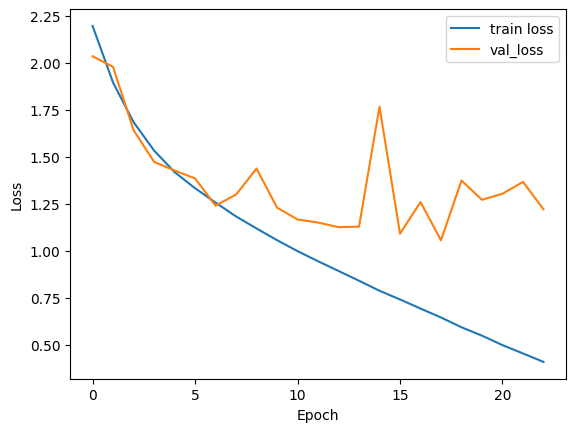

In [11]:
plot_history(history)

For our next experiment, let's try to avoid overfitting by either reducing the complexity of the model, or adding regularisation.

### <span style="color: red;">Exercise:<span>

Remove the last two Conv2D layers of the model, then add a dropout layer (`keras.layers.Dropout`) between the two Dense layers. Train the model and verify that the validation loss flattens.

In [12]:
def make_model():


    # Define your model here

    ## REMOVE
    m = keras.Sequential([
        keras.layers.Input(shape=(32, 32, 3)),
        keras.layers.Rescaling(1.0 / 255),
        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(10, activation='softmax')
    ])

    return m

model = make_model()

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=25,
)

Epoch 1/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.1483 - loss: 2.2497 - val_accuracy: 0.2611 - val_loss: 2.0843
Epoch 2/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3127 - loss: 1.9148 - val_accuracy: 0.4138 - val_loss: 1.6439
Epoch 3/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3991 - loss: 1.6779 - val_accuracy: 0.4631 - val_loss: 1.5173
Epoch 4/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4464 - loss: 1.5464 - val_accuracy: 0.4698 - val_loss: 1.4570
Epoch 5/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4749 - loss: 1.4672 - val_accuracy: 0.5168 - val_loss: 1.3684
Epoch 6/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5028 - loss: 1.3931 - val_accuracy: 0.4968 - val_loss: 1.3979
Epoch 7/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5271 - loss: 1.3334 - val_accuracy: 0.4723 - val_loss: 1.4356
Epoch 8/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.5463 - loss: 1.2696 - val_accurac

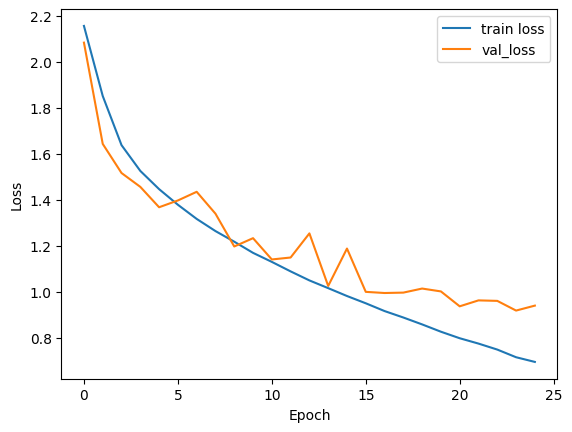

In [13]:
plot_history(history)

In this plot you might see that the validation loss bounces around quite a bit towards the end. As we move closer to the minimum, is would be nice to take smaller steps, to avoid "skipping past" it.
There is a callback for exactly this, namely [`keras.callbacks.ReduceLROnPlateau`](https://keras.io/api/callbacks/reduce_lr_on_plateau/).

Give it a try:

In [14]:
model = make_model()

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05),     # Can start with a higher learning rate this time
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001,
    verbose=1
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=25,
    callbacks=[reduce_lr]   # add the callback
)

Epoch 1/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.2286 - loss: 2.1082 - val_accuracy: 0.4446 - val_loss: 1.5287 - learning_rate: 0.0500
Epoch 2/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4529 - loss: 1.5187 - val_accuracy: 0.4730 - val_loss: 1.4360 - learning_rate: 0.0500
Epoch 3/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5323 - loss: 1.3011 - val_accuracy: 0.5110 - val_loss: 1.2981 - learning_rate: 0.0500
Epoch 4/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5960 - loss: 1.1386 - val_accuracy: 0.5979 - val_loss: 1.1405 - learning_rate: 0.0500
Epoch 5/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6428 - loss: 1.0036 - val_accuracy: 0.4840 - val_loss: 1.5618 - learning_rate: 0.0500
Epoch 6/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6774 - loss: 0.9170 - val_accuracy: 0.5666 - val_loss: 1.2423 - learning_rate: 0.0500
Epoch 7/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7065 - loss: 0.8240

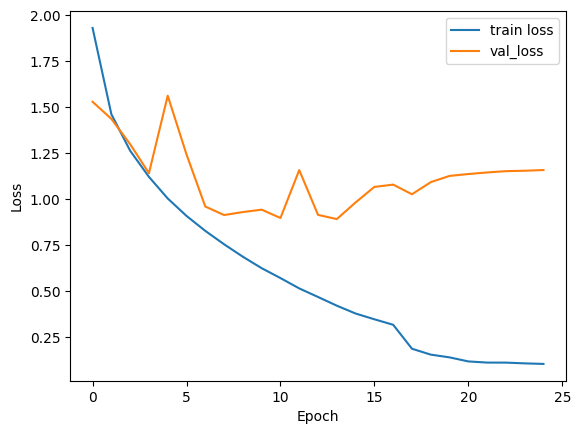

In [15]:
plot_history(history)

## Learning rate schedulers

The above heuristic usually works well, but we can also make more structured approaches. In the [schedulers API](https://keras.io/api/optimizers/learning_rate_schedules/) we find several different strategies for adjusting the learning rate as a function of the training step (batch) number. Since these don't monitor the performance but just look at epoch progression, they are implemented a bit differently, and go as input to the optimiser instead. Let's try an exponential reduction of the learning rate:

In [17]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.05,
    decay_steps=100000,
    decay_rate=0.96,
    #verbose=1
)

model = make_model()

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=30,
)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.2192 - loss: 2.1265 - val_accuracy: 0.4154 - val_loss: 1.6158
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4469 - loss: 1.5578 - val_accuracy: 0.5244 - val_loss: 1.3282
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5335 - loss: 1.3104 - val_accuracy: 0.5569 - val_loss: 1.2470
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5951 - loss: 1.1379 - val_accuracy: 0.5811 - val_loss: 1.1514
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6436 - loss: 1.0139 - val_accuracy: 0.6434 - val_loss: 1.0268
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6824 - loss: 0.9074 - val_accuracy: 0.5924 - val_loss: 1.2210
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7159 - loss: 0.8141 - val_accuracy: 0.6532 - val_loss: 0.9817
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7447 - loss: 0.7301 - val_accuracy:

Before we try out the different schedulers, let's plot how the learning rate is adjusted as training progresses.

First, the exponential decay schedule:

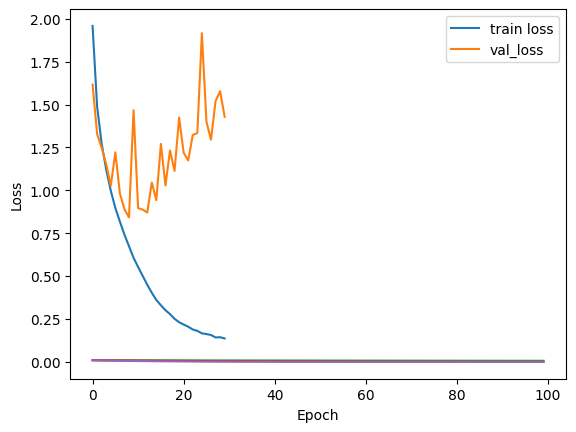

In [19]:
plot_history(history)

exp_schedule_1 = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=25, decay_rate=0.90, name="Decay rate 0.90")
exp_schedule_2 = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=25, decay_rate=0.50, name="Decay rate 0.50")
exp_schedule_3 = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=25, decay_rate=0.20, name="Decay rate 0.20")

num_steps = 100
plt.plot(range(num_steps), exp_schedule_1(range(num_steps)), label=exp_schedule_1.name)
plt.plot(range(num_steps), exp_schedule_2(range(num_steps)), label=exp_schedule_2.name)
plt.plot(range(num_steps), exp_schedule_3(range(num_steps)), label=exp_schedule_3.name)


### <span style="color: red;">Exercise:<span>

Make similar plots for the cosine decay schedule ([`keras.optimizers.schedules.CosineDecay`](https://keras.io/api/optimizers/learning_rate_schedules/cosine_decay/)).

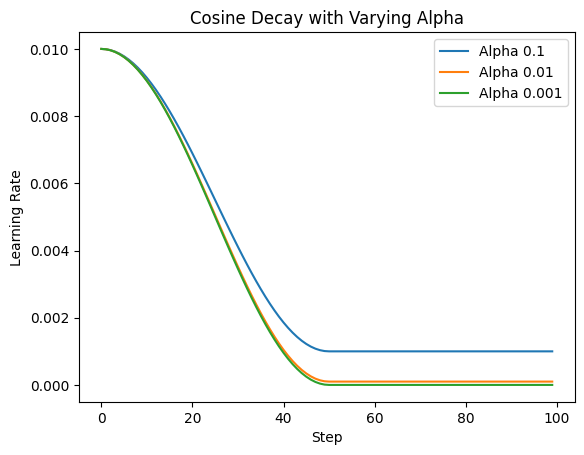

In [24]:
cos_schedule_1 = keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.01, decay_steps=50, alpha=0.1, name="Alpha 0.1")
cos_schedule_2 = keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.01, decay_steps=50, alpha=0.01, name="Alpha 0.01")
cos_schedule_3 = keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.01, decay_steps=50, alpha=0.0001, name="Alpha 0.001")
num_steps = 100
plt.plot(range(num_steps), cos_schedule_1(range(num_steps)), label=cos_schedule_1.name)
plt.plot(range(num_steps), cos_schedule_2(range(num_steps)), label=cos_schedule_2.name)
plt.plot(range(num_steps), cos_schedule_3(range(num_steps)), label=cos_schedule_3.name)
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Cosine Decay with Varying Alpha")
plt.show()

### Write you own scheduler!

Maybe training will be even more efficient if the learning rate goes up and down a bit like so:

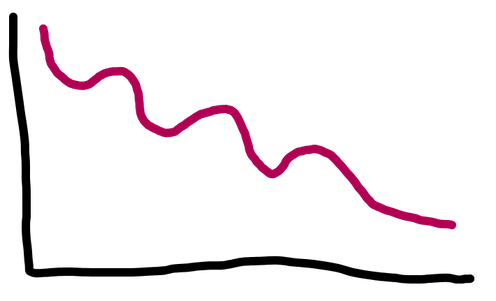





We can make out own scheduling method relatively easily (and be at the forefront of deep learning research) with the learning rate schedules [API](https://keras.io/api/optimizers/learning_rate_schedules/learning_rate_schedule/).

### <span style="color: red;">Exercise:<span>

Implement the `__call__` function below, so that it adjusts the learning rate in a useful way, either like in the drawing above (which is technically called _linear cosine decay_), or something else that you believe would give imploved performance.

Maybe even add some randomness?

In [36]:
class MyLRSchedule(keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, initial_learning_rate, linear_decay_steps=10000, total_steps=30000, min_learning_rate=1e-5):
        self.initial_learning_rate = initial_learning_rate
        self.linear_decay_steps = linear_decay_steps
        self.total_steps = total_steps
        self.min_learning_rate = min_learning_rate

    def __call__(self, step):
        # Convert np.pi to a TensorFlow constant
        pi_tensor = tf.constant(np.pi, dtype=tf.float32)

        # Cast step to float32
        step = tf.cast(step, tf.float32)  # Cast step to float32

        # Cast other relevant variables to float32
        linear_decay_steps = tf.cast(self.linear_decay_steps, tf.float32)
        total_steps = tf.cast(self.total_steps, tf.float32)


        # Use tf.cond for conditional logic within TensorFlow graph
        learning_rate = tf.cond(
            step < linear_decay_steps,  # Use the casted variables
            lambda: self.initial_learning_rate * (1.0 - step / linear_decay_steps),  # Linear decay
            lambda: self.min_learning_rate + 0.5 * (self.initial_learning_rate - self.min_learning_rate) * (1 + tf.cos(pi_tensor * (step - linear_decay_steps) / (total_steps - linear_decay_steps)))  # Cosine decay
        )

        # Ensure learning rate doesn't go below minimum
        learning_rate = tf.maximum(learning_rate, self.min_learning_rate)
        return learning_rate

Put it to the test:

In [37]:
# Add the scheduler (you can choose the initial learning rate yourself)
optimizer = keras.optimizers.SGD(learning_rate=MyLRSchedule(0.1))

model = make_model()

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=30,
)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.2011 - loss: 2.1604 - val_accuracy: 0.4672 - val_loss: 1.4808
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4610 - loss: 1.4976 - val_accuracy: 0.4901 - val_loss: 1.4463
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5576 - loss: 1.2444 - val_accuracy: 0.5547 - val_loss: 1.2569
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6172 - loss: 1.0785 - val_accuracy: 0.6444 - val_loss: 1.0131
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6714 - loss: 0.9298 - val_accuracy: 0.6588 - val_loss: 0.9620
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7161 - loss: 0.8027 - val_accuracy: 0.6383 - val_loss: 1.0490
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7447 - loss: 0.7137 - val_accuracy: 0.7083 - val_loss: 0.8634
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7776 - loss: 0.6264 - val_accuracy

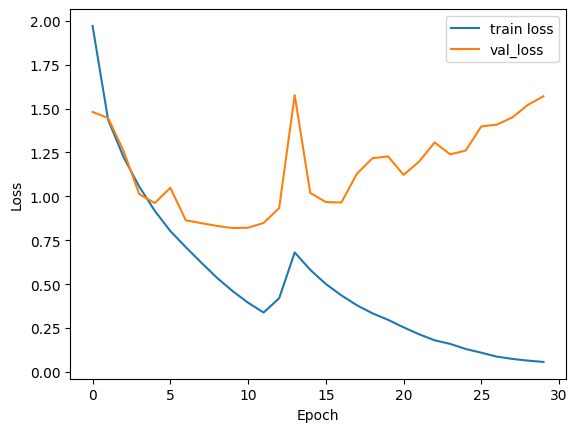

In [38]:
plot_history(history)